# BERT Model Clean

This sheet is used to train a BERT model over imported labeled data. 

Current possible BERT versions:

*   bert_en_uncased_L-12_H-768_A-12
*   talkingheads
*   expert_trained
*   bert_en_wwm_uncased_L-24_H-1024_A-16/4
*   lamb
*   electra

This sheet should be used in Google Collab

# Install Packages

In [1]:
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 7.3MB/s 


In [2]:
!pip install tf-models-official==2.4.0

     |████████████████████████████████| 1.1MB 8.0MB/s 
     |████████████████████████████████| 1.2MB 53.5MB/s 
     |████████████████████████████████| 358kB 44.5MB/s 
     |████████████████████████████████| 174kB 42.6MB/s 
     |████████████████████████████████| 38.2MB 145kB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 686kB 38.0MB/s 
     |████████████████████████████████| 645kB 50.6MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22245 sha256=3f4689ef7384816ba1dde23b4f76f08c925d839f320ce1057f9ff72e41d0142d
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134e3a01df0c723816835dd08db
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=9640d5411a4f408966c50666e430054f5d17058df8da76e044324550fdafcd07
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e6262147

# Connect to GPU and Import Packages

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import os
import shutil

import pandas as pd
import numpy as np
import math

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [5]:
google_drive_path = "/content/drive/My Drive/catchfire/"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data 

In [8]:
raw_data = pd.read_excel(open('labeled_data_5_13_finKeywordEdit.xlsx', 'rb'),
              sheet_name='Label_Data')

In [9]:
column_list = [
      "text",
      "anger_thresh",
      "fear_thresh",
      "joy_thresh",
      "sad_thresh",
      "analytical_thresh",
      "confident_thresh",
      "tentative_thresh"
]

x_list = [
      "text"
]

y_list = [
      "anger_thresh",
      "fear_thresh",
      "joy_thresh",
      "sad_thresh",
      "analytical_thresh",
      "confident_thresh",
      "tentative_thresh"
]

In [10]:
featured_data = raw_data[column_list].head(160000)

In [11]:
featured_data["text"] = featured_data["text"].fillna(value='')

# Split into Train and Test

In [12]:
x_data = np.array(featured_data[x_list], dtype=np.object)
y_data = np.array(featured_data[y_list], dtype=np.float)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [13]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,7))
y_test = np.asarray(y_test).astype('float32').reshape((-1,7))

# Select BERT Model

In [14]:
bert_model_name = 'electra' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',
    'talkingheads':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/2',
    'expert_trained':
        'https://tfhub.dev/google/experts/bert/wiki_books/sst2/2',
    'bert_en_wwm_uncased_L-24_H-1024_A-16/4':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/4',
    'lamb':
        'https://tfhub.dev/tensorflow/lambert_en_uncased_L-24_H-1024_A-16/2',
    'electra':
        'https://tfhub.dev/google/electra_base/2'
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talkingheads':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'expert_trained':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16/4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'lamb':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_base/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# Build Model

In [15]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(7, activation="sigmoid", name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [16]:
classifier_model = build_classifier_model()

In [17]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

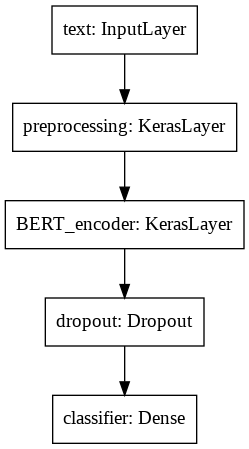

In [18]:
tf.keras.utils.plot_model(classifier_model)

# Setup Loss and Metrics. Then Compile

In [19]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.metrics.BinaryAccuracy(),tf.keras.metrics.TopKCategoricalAccuracy(k=2)]

In [20]:
epochs = 10
batch_size = 64
steps_per_epoch = math.ceil(X_train.shape[0]/batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [21]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# Train Model

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               shuffle=True,
                               validation_split=0.2,
                               epochs=epochs)

Training model with https://tfhub.dev/google/electra_base/2
Epoch 1/10
 717/3200 [=====>........................] - ETA: 21:25 - loss: 0.4370 - binary_accuracy: 0.7932 - top_k_categorical_accuracy: 0.4306

# Measure Model Performance

In [ ]:
classifier_model.evaluate(X_test, y_test)

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
k_acc = history_dict['top_k_categorical_accuracy']
val_k_acc = history_dict['val_top_k_categorical_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
k_acc = history_dict['top_k_categorical_accuracy']
val_k_acc = history_dict['val_top_k_categorical_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, k_acc, 'r', label='Training k acc')
plt.plot(epochs, val_k_acc, 'b', label='Validation k acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Save Model

In [ ]:
dataset_name = 'electra_5_18_high_lr'
saved_model_path = google_drive_path+'{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)